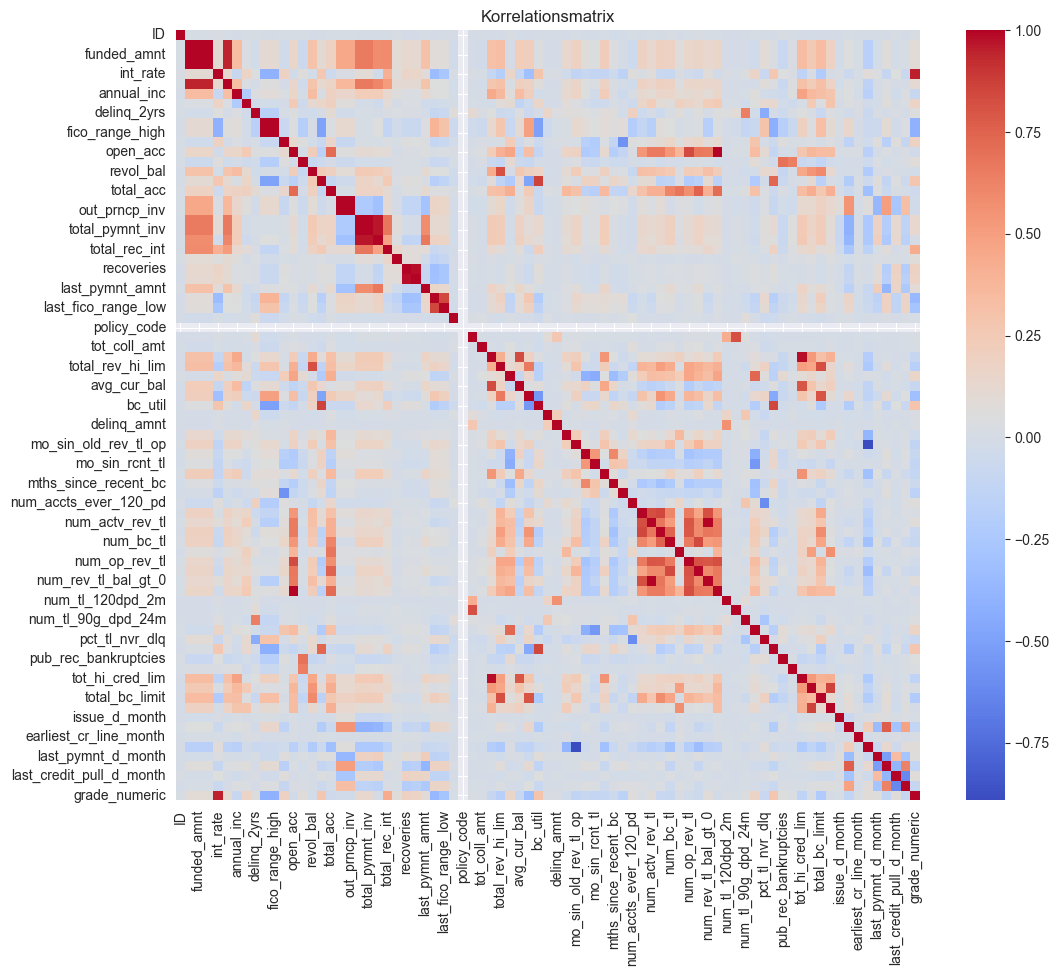

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123123)

# Load csv file with pandas
df = pd.read_csv('data/loan-10k.lrn.csv')

# drop all na values
df = df.dropna()

grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
numerical_df = df
numerical_df['grade_numeric'] = numerical_df['grade'].map(grade_mapping)
numerical_df = df.select_dtypes(include=[np.number])

# Berechne die Korrelationsmatrix
correlation_matrix = numerical_df.corr()


# Visualisiere die Korrelationsmatrix , annot=False
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Korrelationsmatrix")
plt.show()

# X and y
X = df.drop('grade', axis=1)  # shape: (n_samples, 8)
# y = df['grade'].values.reshape(-1, 1)  # shape: (n_samples, 1)
y = pd.get_dummies(df['grade']).astype(float).values


In [29]:
#Preprocess dataset
date_prefixes = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
today = pd.Timestamp.today()
# today = pd.Timestamp().now().normalize()
# Transform the year and month columns into datetime
for prefix in date_prefixes:
    X[f'{prefix}_year'] = pd.to_numeric(X[f'{prefix}_year'], errors='coerce')
    X[f'{prefix}_month'] = pd.to_numeric(X[f'{prefix}_month'], errors='coerce')
    X[prefix] = pd.to_datetime(
        pd.DataFrame({
            'year': X[f'{prefix}_year'],
            'month': X[f'{prefix}_month'],
            'day': 1
        }),
        errors='coerce'
    )
    X[f'{prefix}_age_days'] = (today - X[prefix]).dt.days
    X[f'{prefix}_age_days'] = X[f'{prefix}_age_days'].fillna(X[f'{prefix}_age_days'].mean())

X = X.drop(columns=[f"{prefix}_year" for prefix in date_prefixes] +
                               [f"{prefix}_month" for prefix in date_prefixes],
                     errors='ignore')

# Drop original date columns
X = X.drop(columns=date_prefixes)

# Transform term column
if 'term' in X.columns:
    X['term'] = X['term'].str.extract(r'(\d+)').astype(float)

# Transform emp_length column
# emp_length: '< 1 year' etc.
emp_map = {'< 1 year': 0.5, '10+ years': 11}
X['emp_length'] = X['emp_length'].replace(emp_map)
X['emp_length'] = X['emp_length'].str.extract(r'(\d+)').astype(float).fillna(X['emp_length'])

# Transform binary flags
bin_map = {'N': 0, 'n': 0, 'Y': 1, 'y': 1}
for col in ['hardship_flag', 'debt_settlement_flag', 'pymnt_plan']:
    if col in X.columns:
        X[col] = X[col].map(bin_map)

# Transform categorical features
if 'disbursement_method' in X.columns:
    X['disbursement_method'] = X['disbursement_method'].map({'Cash': 0, 'DirectPay': 1})
if 'application_type' in X.columns:
    X['application_type'] = X['application_type'].map({'Individual': 0, 'Joint App': 1})
if 'initial_list_status' in X.columns:
    X['initial_list_status'] = X['initial_list_status'].map({'f': 0, 'w': 1})

# Transform Verification status
verification_map = {'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
if 'verification_status' in X.columns:
    X['verification_status'] = X['verification_status'].map(verification_map)

# loan_status (optional)
status_map = {
    'Fully Paid': 0,
    'Current': 1,
    'In Grace Period': 2,
    'Late (16-30 days)': 3,
    'Late (31-120 days)': 4,
    'Charged Off': 5
}
if 'loan_status' in X.columns:
    X['loan_status'] = X['loan_status'].map(status_map)

numerical_features = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
    'installment', 'emp_length', 'annual_inc', 'verification_status',
    'loan_status', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
    'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high',
    'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code',
    'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
    'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
    'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
    'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',
    'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
    'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
    'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
    'total_il_high_credit_limit'
]
numerical_features += [f'{prefix}_age_days' for prefix in date_prefixes]

categorical_features = ['purpose', 'home_ownership']

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='drop'
)

X_processed = preprocessor.fit_transform(X)

### Split the cells

In [30]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=123123)

print(X_train.shape)
print(y_train.shape)

(7000, 95)
(7000, 7)


## Train the model


=== Training Model 1/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 7, 'lr': 0.05, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945905
           Test Accuracy = 0.2993
Epoch 2000: Loss = 1.586932
           Test Accuracy = 0.2993
Epoch 4000: Loss = 0.879550
           Test Accuracy = 0.7040
Epoch 6000: Loss = 0.361634
           Test Accuracy = 0.8510
Epoch 8000: Loss = 0.305318
           Test Accuracy = 0.8580
Epoch 10000: Loss = 0.253330
           Test Accuracy = 0.9010
Epoch 12000: Loss = 0.220683
           Test Accuracy = 0.9047
Epoch 14000: Loss = 0.204204
           Test Accuracy = 0.9083


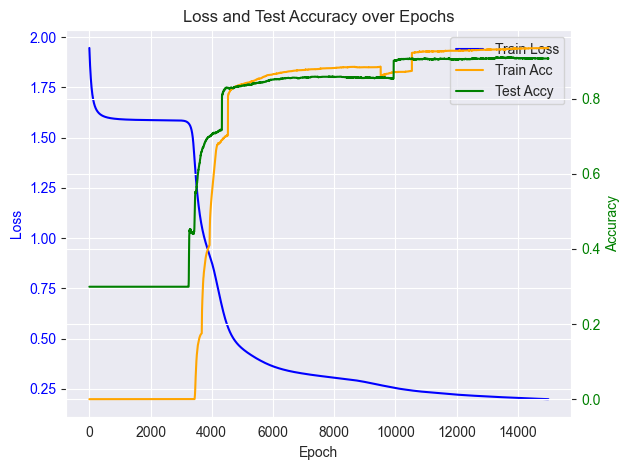


Minimum loss: 0.198119
Maximum train accuracy: 0.9350
Maximum test accuracy: 0.9097

=== Training Model 2/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 30, 'hidden2_size': 20, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945930
           Test Accuracy = 0.2997
Epoch 2000: Loss = 1.610932
           Test Accuracy = 0.2993
Epoch 4000: Loss = 1.593823
           Test Accuracy = 0.2993
Epoch 6000: Loss = 1.587161
           Test Accuracy = 0.2993
Epoch 8000: Loss = 1.083420
           Test Accuracy = 0.5983
Epoch 10000: Loss = 0.526511
           Test Accuracy = 0.8283
Epoch 12000: Loss = 0.379745
           Test Accuracy = 0.8513
Epoch 14000: Loss = 0.296255
           Test Accuracy = 0.8823


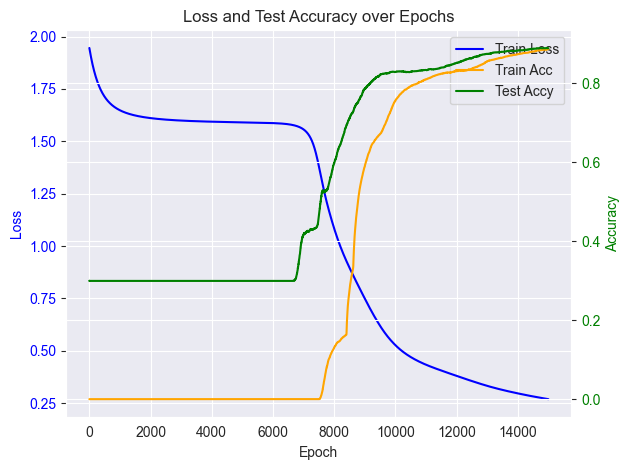


Minimum loss: 0.268659
Maximum train accuracy: 0.8860
Maximum test accuracy: 0.8890

=== Training Model 3/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945912
           Test Accuracy = 0.2877
Epoch 2000: Loss = 1.609723
           Test Accuracy = 0.2993
Epoch 4000: Loss = 1.574846
           Test Accuracy = 0.3477
Epoch 6000: Loss = 0.939345
           Test Accuracy = 0.6703
Epoch 8000: Loss = 0.496629
           Test Accuracy = 0.8310
Epoch 10000: Loss = 0.351925
           Test Accuracy = 0.8557
Epoch 12000: Loss = 0.271978
           Test Accuracy = 0.8817
Epoch 14000: Loss = 0.225385
           Test Accuracy = 0.8950


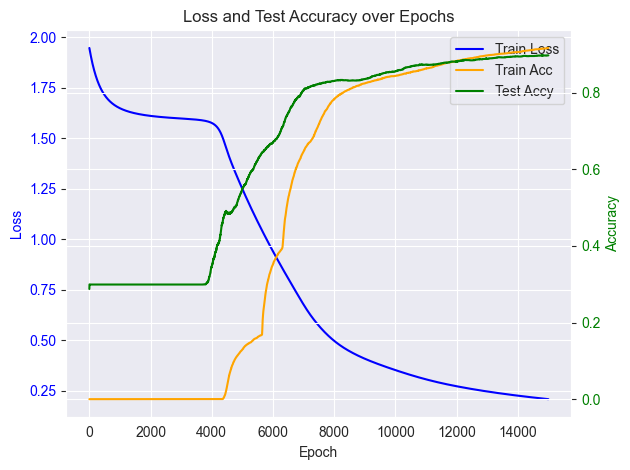


Minimum loss: 0.208111
Maximum train accuracy: 0.9170
Maximum test accuracy: 0.8977

=== Training Model 4/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 90, 'hidden2_size': 75, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945874
           Test Accuracy = 0.3210
Epoch 2000: Loss = 1.608356
           Test Accuracy = 0.2993
Epoch 4000: Loss = 1.304872
           Test Accuracy = 0.5007
Epoch 6000: Loss = 0.597268
           Test Accuracy = 0.8173
Epoch 8000: Loss = 0.363954
           Test Accuracy = 0.8620
Epoch 10000: Loss = 0.274508
           Test Accuracy = 0.8860
Epoch 12000: Loss = 0.224909
           Test Accuracy = 0.8957
Epoch 14000: Loss = 0.191683
           Test Accuracy = 0.9020


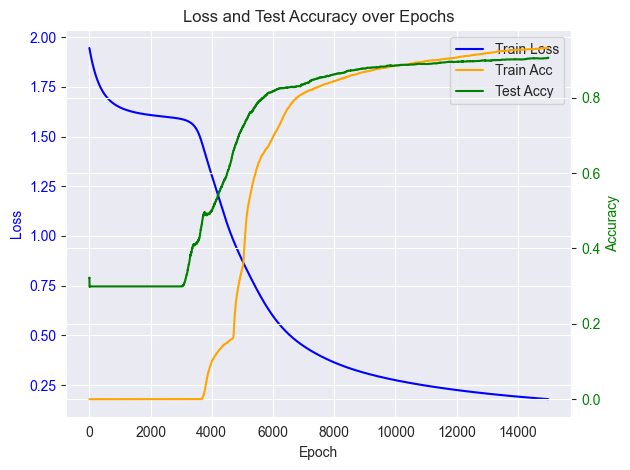


Minimum loss: 0.178969
Maximum train accuracy: 0.9323
Maximum test accuracy: 0.9063

=== Training Model 5/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0}
Epoch 0: Loss = 1.945940
           Test Accuracy = 0.3027
Epoch 2000: Loss = 1.610330
           Test Accuracy = 0.2993
Epoch 4000: Loss = 1.585611
           Test Accuracy = 0.3000
Epoch 6000: Loss = 0.962187
           Test Accuracy = 0.6613
Epoch 8000: Loss = 0.505663
           Test Accuracy = 0.8267
Epoch 10000: Loss = 0.358680
           Test Accuracy = 0.8560
Epoch 12000: Loss = 0.273411
           Test Accuracy = 0.8870
Epoch 14000: Loss = 0.227783
           Test Accuracy = 0.8947


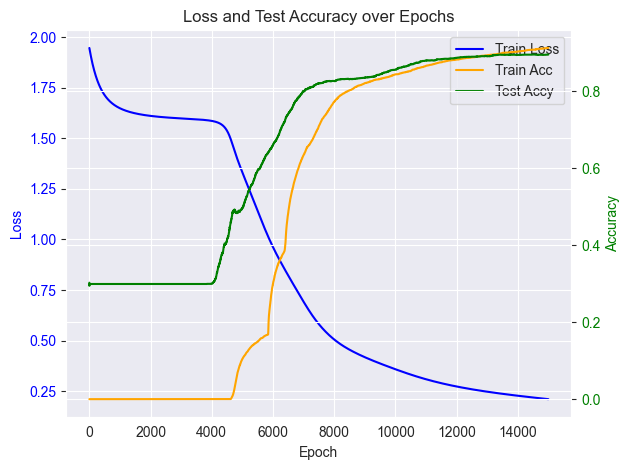


Minimum loss: 0.210871
Maximum train accuracy: 0.9127
Maximum test accuracy: 0.8957

=== Training Model 6/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.001}
Epoch 0: Loss = 1.945961
           Test Accuracy = 0.2877
Epoch 2000: Loss = 1.610449
           Test Accuracy = 0.2993
Epoch 4000: Loss = 1.583064
           Test Accuracy = 0.3093
Epoch 6000: Loss = 0.888643
           Test Accuracy = 0.6980
Epoch 8000: Loss = 0.474926
           Test Accuracy = 0.8337
Epoch 10000: Loss = 0.347368
           Test Accuracy = 0.8677
Epoch 12000: Loss = 0.277215
           Test Accuracy = 0.8897
Epoch 14000: Loss = 0.235337
           Test Accuracy = 0.8937


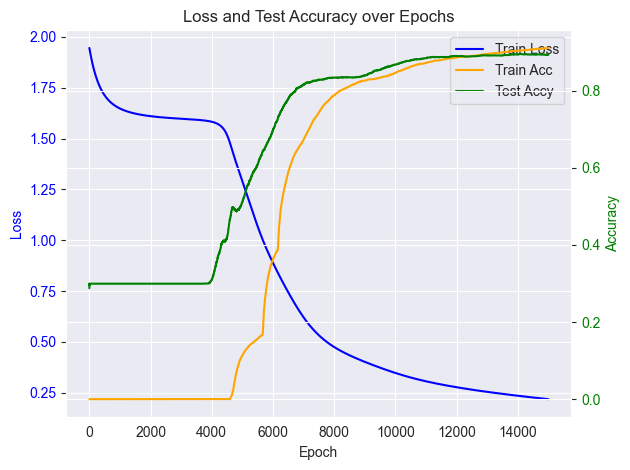


Minimum loss: 0.218572
Maximum train accuracy: 0.9104
Maximum test accuracy: 0.8947

=== Training Model 7/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.003}
Epoch 0: Loss = 1.945951
           Test Accuracy = 0.2837
Epoch 2000: Loss = 1.610682
           Test Accuracy = 0.2993
Epoch 4000: Loss = 1.590508
           Test Accuracy = 0.2993
Epoch 6000: Loss = 1.077354
           Test Accuracy = 0.6163
Epoch 8000: Loss = 0.561482
           Test Accuracy = 0.8247
Epoch 10000: Loss = 0.395567
           Test Accuracy = 0.8430
Epoch 12000: Loss = 0.308700
           Test Accuracy = 0.8843
Epoch 14000: Loss = 0.261934
           Test Accuracy = 0.8913


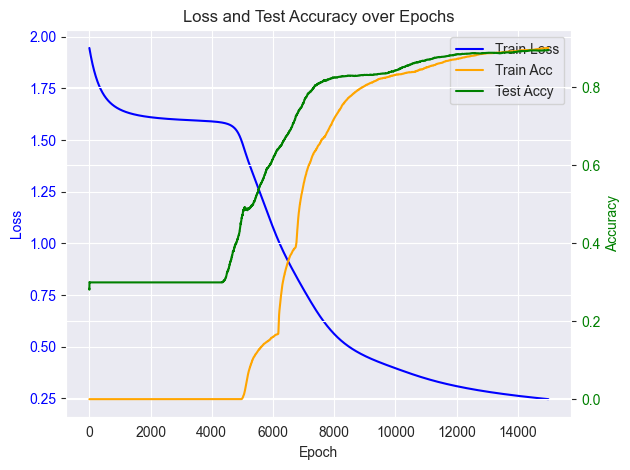


Minimum loss: 0.245812
Maximum train accuracy: 0.9003
Maximum test accuracy: 0.8947

=== Training Model 8/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945987
           Test Accuracy = 0.2810
Epoch 2000: Loss = 1.610839
           Test Accuracy = 0.2993
Epoch 4000: Loss = 1.589324
           Test Accuracy = 0.2993
Epoch 6000: Loss = 1.037357
           Test Accuracy = 0.6357
Epoch 8000: Loss = 0.525429
           Test Accuracy = 0.8263
Epoch 10000: Loss = 0.375865
           Test Accuracy = 0.8427
Epoch 12000: Loss = 0.287026
           Test Accuracy = 0.8813
Epoch 14000: Loss = 0.236939
           Test Accuracy = 0.8927


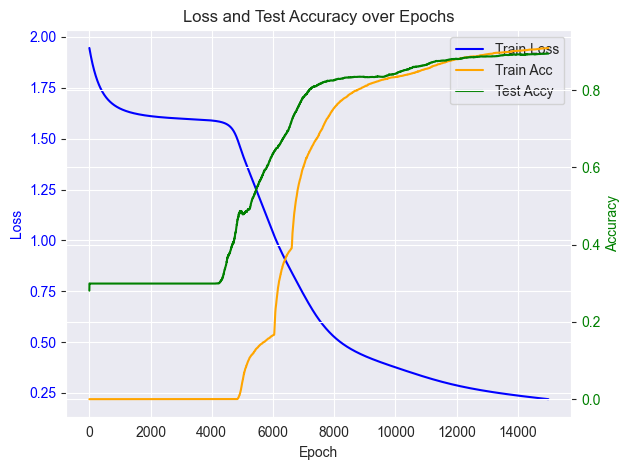


Minimum loss: 0.219323
Maximum train accuracy: 0.9093
Maximum test accuracy: 0.8947

=== Training Model 9/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'sigmoid', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.955483
           Test Accuracy = 0.0067
Epoch 2000: Loss = 1.585691
           Test Accuracy = 0.2993

Stopped after epoch 3021. No improvement for 2000 epochs.


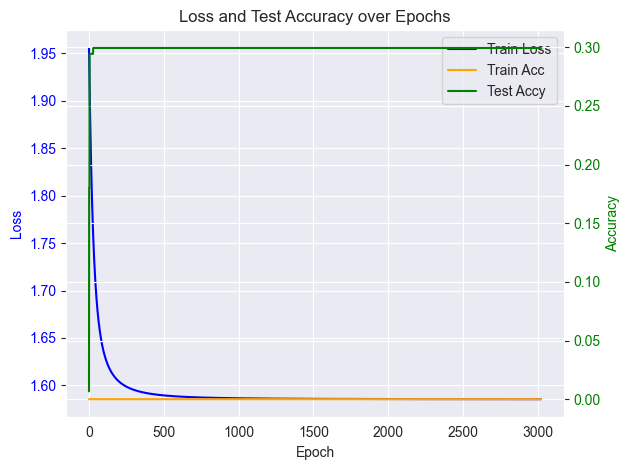


Minimum loss: 1.585566
Maximum train accuracy: 0.0000
Maximum test accuracy: 0.2993

=== Training Model 10/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'tanh', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945877
           Test Accuracy = 0.3170
Epoch 2000: Loss = 1.545211
           Test Accuracy = 0.4047
Epoch 4000: Loss = 0.679737
           Test Accuracy = 0.8110
Epoch 6000: Loss = 0.444347
           Test Accuracy = 0.8417
Epoch 8000: Loss = 0.360008
           Test Accuracy = 0.8667
Epoch 10000: Loss = 0.318387
           Test Accuracy = 0.8700
Epoch 12000: Loss = 0.290635
           Test Accuracy = 0.8703
Epoch 14000: Loss = 0.261645
           Test Accuracy = 0.8773


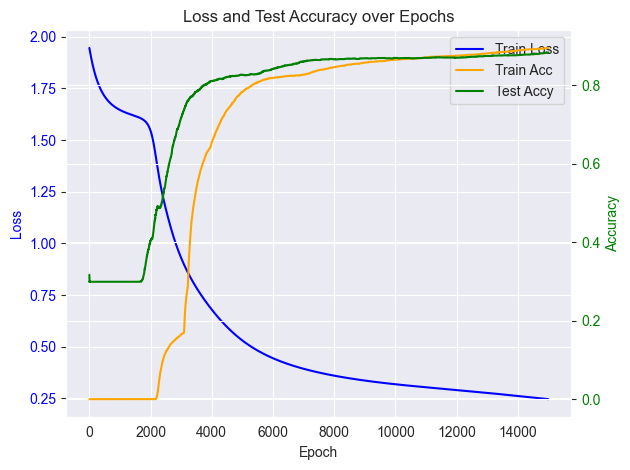


Minimum loss: 0.246311
Maximum train accuracy: 0.8954
Maximum test accuracy: 0.8837

=== Training Model 11/14 ===
Parameters: {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45, 'output_size': 7, 'lr': 0.1, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945899
           Test Accuracy = 0.2993
Epoch 2000: Loss = 0.156630
           Test Accuracy = 0.9070
Epoch 4000: Loss = 0.076150
           Test Accuracy = 0.9120
Epoch 6000: Loss = 0.040166
           Test Accuracy = 0.9097
Epoch 8000: Loss = 0.022475
           Test Accuracy = 0.9077
Epoch 10000: Loss = 0.013509
           Test Accuracy = 0.9080
Epoch 12000: Loss = 0.008747
           Test Accuracy = 0.9060
Epoch 14000: Loss = 0.006155
           Test Accuracy = 0.9057


In [ ]:
import pandas as pd
import numpy as np
# Loss and Accuracy
from sklearn.metrics import accuracy_score
from Implementation.NeuralNetwork import NeuralNetwork

def train_model_loan(model_params, X_train, y_train,
                X_test=None, y_test=None,
                max_epochs=30000,
                tolerance=1e-3,
                patience=10000,
                print_every=100):

    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden'],
        l2_lambda=model_params['l2_lambda'],
        multiclass=True if model_params['output_size'] > 1 else False
    )

    losses = []
    train_accuracies = []
    test_accuracies = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        # Train-Accuracy berechnen
        y_pred_train = model.predict(X_train)
        y_pred_train_bin = (y_pred_train > 0.5).astype(int)
        acc_train = accuracy_score(y_train, y_pred_train_bin)
        train_accuracies.append(acc_train)

        if X_test is not None and y_test is not None:
            y_test_proba = model.predict(X_test)
            y_pred_labels = np.argmax(y_test_proba, axis=1)
            y_true_labels = np.argmax(y_test, axis=1)

            # calc accuracy
            acc = accuracy_score(y_true_labels, y_pred_labels)
            test_accuracies.append(acc)

        if print_every and epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f}")
            if X_test is not None:
                print(f"           Test Accuracy = {acc:.4f}")

        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot Loss und Test Accuracy
    fig, ax1 = plt.subplots()

    ax1.plot(losses, label="Train Loss", color='blue')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(train_accuracies, label="Train Acc", color='orange')
    if test_accuracies:
        ax2.plot(test_accuracies, label="Test Accy", color='green')
        ax2.set_ylabel("Accuracy", color='green')
        ax2.tick_params(axis='y', labelcolor='green')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    plt.title("Loss and Test Accuracy over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    print(f"Maximum train accuracy: {max(train_accuracies):.4f}")
    if test_accuracies:
        print(f"Maximum test accuracy: {max(test_accuracies):.4f}")

    return losses, train_accuracies, test_accuracies




parameter_grid = [
    # Neurons
    {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu','l2_lambda': 1e-4}, # underfitting example
    {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 7, 'lr': 0.05,  'activation_hidden': 'relu','l2_lambda': 1e-4}, # underfitting example, adjusted learning-rate
    {'input_size': 95, 'hidden1_size': 30, 'hidden2_size': 20,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-4}, # underfitting example
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-4}, # rule of thumb
    {'input_size': 95, 'hidden1_size': 90, 'hidden2_size': 75,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-4}, # overfitting example
    
    # Regularization
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.0},
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-3},
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 3e-3},
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-4},

    # activation functions
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'sigmoid', 'l2_lambda': 1e-4},
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'tanh', 'l2_lambda': 1e-4},

    # Learning rates
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.1,  'activation_hidden': 'relu', 'l2_lambda': 1e-4},
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-4},
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.001,  'activation_hidden': 'relu', 'l2_lambda': 1e-4},
    {'input_size': 95, 'hidden1_size': 67, 'hidden2_size': 45,  'output_size': 7, 'lr': 0.0001,  'activation_hidden': 'relu', 'l2_lambda': 1e-4}

]

results = []
for i, params in enumerate(parameter_grid):
    print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")
    print(f"Parameters: {params}")

    losses, train_accuracies, test_accuracies = train_model_loan(
        params,
        X_train, y_train,
        X_test=X_test, y_test=y_test,
        max_epochs=15000,
        tolerance=1e-3,
        patience=2000,
        print_every=2000
    )

    results.append({
        'params': params,
        'min_loss': min(losses),
        'max_accuracy': max(test_accuracies) if test_accuracies else None
    })


## Pytorch

In [ ]:
# Data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import torch

# Features: float32
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)

# Targets: float32 UND als Spaltenvektor (N, 1)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


model = nn.Sequential(
    nn.Linear(8, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
    nn.Sigmoid()
)

# binary cross-entropy loss
criterion = nn.BCELoss()

# Optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.01)
lr = 0.1

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()

    # Forward-Pass
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    # Zero gradients because PyTorch accumulates gradients
    model.zero_grad()

    # Backward-Pass (clac gradients)
    loss.backward()

    # Update manuelly
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad

    # print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [ ]:
# Predict on test
outputs_test = model(X_test_torch)
# Convert predictions to binary with a threshold of 0.5
y_pred_test = (outputs_test >= 0.5).float()
# Calculate accuracy
accuracy_test = (y_pred_test == y_test_torch).float().mean()
print(f"Test Accuracy: {accuracy_test:.4f}")
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test_torch.numpy(), y_pred_test.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (PyTorch Model)')
plt.show()

In [ ]:
import numpy as np

# Base class for layers
class Layer:
    def forward(self, input):
        raise NotImplementedError

    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

# Dense (fully connected) layer
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.bias = np.zeros((1, output_size))

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(self.input.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * np.mean(output_gradient, axis=0, keepdims=True)
        return input_gradient

# Activation functions
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_gradient, learning_rate):
        return self.activation_prime(self.input) * output_gradient

# Specific activation functions
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

# Softmax-Schicht für Multiclass
class Softmax(Layer):
    def forward(self, input):
        # numerisch stabil
        exps = np.exp(input - np.max(input, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, output_gradient, learning_rate):
        # output_gradient: dL/dy, y = Softmax(input)
        # dL/dx = Jacobian_softmax · dL/dy
        batch_size, num_classes = self.output.shape
        input_gradient = np.empty_like(output_gradient)

        # pro Sample
        for i in range(batch_size):
            y = self.output[i].reshape(-1, 1)
            # Jacobian: diag(y) - y y^T
            jacobian = np.diagflat(y) - np.dot(y, y.T)
            input_gradient[i] = np.dot(jacobian, output_gradient[i])

        return input_gradient

# Loss function
class MeanSquaredError:
    def loss(self, predicted, actual):
        return np.mean(np.power(predicted - actual, 2))

    def gradient(self, predicted, actual):
        return 2 * (predicted - actual) / actual.size

# Neural network class
class NeuralNetwork2:
    def __init__(self):
        self.layers = []
        self.loss_fn = MeanSquaredError()

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.predict(x_train)
            loss = self.loss_fn.loss(output, y_train)
            grad = self.loss_fn.gradient(output, y_train)

            for layer in reversed(self.layers):
                grad = layer.backward(grad, learning_rate)

            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")


In [ ]:
nn = NeuralNetwork2()
nn.add(Dense(8, 4))
nn.add(Activation(relu, relu_prime))
nn.add(Dense(4, 1))
nn.add(Activation(sigmoid, sigmoid_prime))

nn.train(X_train, y_train, epochs=1000, learning_rate=0.1)

# Predictions
preds = nn.predict(X_train)
pred_classes = (preds >= 0.5).astype(int)

true_classes = y_train.reshape(-1, 1)

# Accuracy
accuracy = np.mean(pred_classes == true_classes)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_nn = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Custom NN)')
plt.show()


In [ ]:
def get_activation(name):
    if name == 'relu':
        return relu, relu_prime
    elif name == 'sigmoid':
        return sigmoid, sigmoid_prime
    elif name == 'tanh':
        return np.tanh, lambda x: 1 - np.tanh(x)**2
    else:
        raise ValueError(f"Unknown activation: {name}")

def train_model_LLM(model_params, X_train, y_train,
                    X_test=None, y_test=None,
                    max_epochs=10000,
                    tolerance=1e-3,
                    patience=1000,
                    print_every=1000):

    # 1) Netzwerk instanziieren
    nn = NeuralNetwork2()
    # dynamisch gewählte Hidden-Aktivierung
    act, act_prime = get_activation(model_params['activation_hidden'])

    nn.add(Dense(model_params['input_size'], model_params['hidden1_size']))
    nn.add(Activation(act, act_prime))
    nn.add(Dense(model_params['hidden1_size'], model_params['hidden2_size']))
    nn.add(Activation(act, act_prime))
    nn.add(Dense(model_params['hidden2_size'], model_params['output_size']))
    # Multiclass vs. Binary
    if model_params['output_size'] > 1:
        nn.add(Softmax())
    else:
        # für binär: Sigmoid
        nn.add(Activation(sigmoid, sigmoid_prime))

    losses = []
    train_accuracies = []
    test_accuracies = []
    best_loss = float('inf')
    no_improvement = 0


    # 2) Eine Epoche trainieren und Loss zurückbekommen
    # Annahme: train_epoch führt 1 Epoche aus und returned den Loss
    loss = nn.train(X_train, y_train, learning_rate=model_params['lr'])
    losses.append(loss)

    # 3) Vorhersage & Accuracy
    y_pred_train = nn.predict(X_train)
    if model_params['output_size'] > 1:
        # Multiclass: argmax
        y_pred_labels = np.argmax(y_pred_train, axis=1)
        y_true_labels = (np.argmax(y_train, axis=1)
                         if y_train.ndim > 1 else y_train)
    else:
        # Binary: 0.5 Threshold
        y_pred_labels = (y_pred_train > 0.5).astype(int).ravel()
        y_true_labels = y_train.ravel()

    acc_train = accuracy_score(y_true_labels, y_pred_labels)
    train_accuracies.append(acc_train)

    if X_test is not None and y_test is not None:
        y_pred_test = nn.predict(X_test)
        if model_params['output_size'] > 1:
            y_pred_test_labels = np.argmax(y_pred_test, axis=1)
            y_true_test_labels = (np.argmax(y_test, axis=1)
                                  if y_test.ndim > 1 else y_test)
        else:
            y_pred_test_labels = (y_pred_test > 0.5).astype(int).ravel()
            y_true_test_labels = y_test.ravel()

        acc_test = accuracy_score(y_true_test_labels, y_pred_test_labels)
        test_accuracies.append(acc_test)

    # Plots (unverändert)
    fig, ax1 = plt.subplots()
    ax1.plot(losses, label="Train Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax2 = ax1.twinx()
    ax2.plot(train_accuracies, label="Train Acc")
    if test_accuracies:
        ax2.plot(test_accuracies, label="Test Acc")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title("Loss and Accuracy over Epochs")
    plt.grid(True)
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    print(f"Maximum train accuracy: {max(train_accuracies):.4f}")
    if test_accuracies:
        print(f"Maximum test accuracy: {max(test_accuracies):.4f}")

    return losses, train_accuracies, test_accuracies


parameter_grid = [
    # Regularization - Comparison
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.0},
    {'input_size': 8, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 1, 'lr': 0.05,  'activation_hidden': 'sigmoid', 'l2_lambda': 0.001}
]
